In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
import pickle
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../src')

In [4]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_melanoma.h5ad')
adata

AnnData object with n_obs × n_vars = 4804 × 3392
    obs: 'X', 'Y', 'cell_type', 'author_cell_type', 'cell_type_int'
    uns: 'author_cell_type_colors', 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

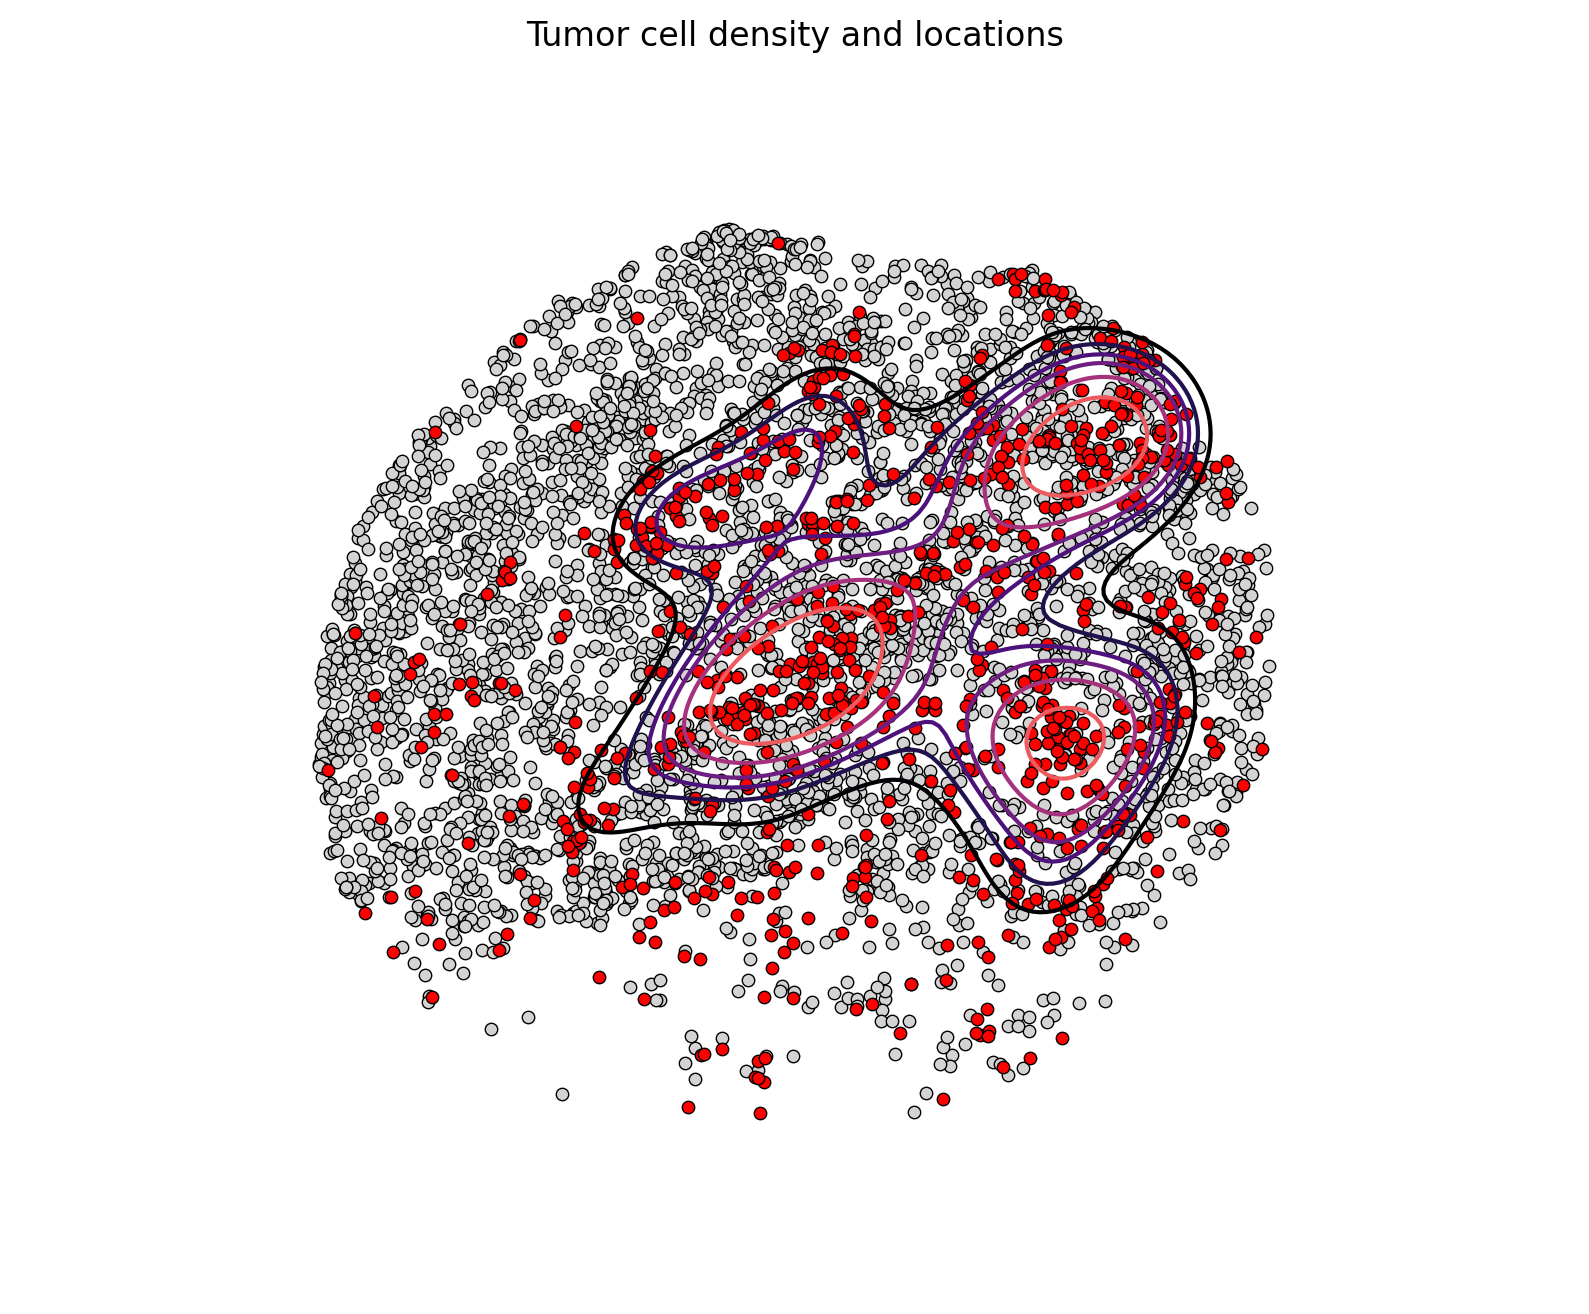

In [5]:
tumor_mask = adata.obs['cell_type'] == 'Tumor 1'
fig, ax = plt.subplots(figsize=(10,8))
x = adata.obsm['spatial'][tumor_mask,0]
y = adata.obsm['spatial'][tumor_mask,1]

ax.scatter(adata.obsm['spatial'][~tumor_mask,0], 
    adata.obsm['spatial'][~tumor_mask,1], alpha=1, color='lightgrey', s=20, 
    linewidth=0.5, edgecolor='black')

ax.scatter(adata.obsm['spatial'][tumor_mask,0], 
    adata.obsm['spatial'][tumor_mask,1], alpha=1, 
    color='red', s=20, linewidth=0.5, edgecolor='black')

sns.kdeplot(x=x, y=y, cmap='magma', fill=False, ax=ax, levels=7, thresh=0.4)


ax.axis('equal')
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Tumor cell density and locations')
plt.show()

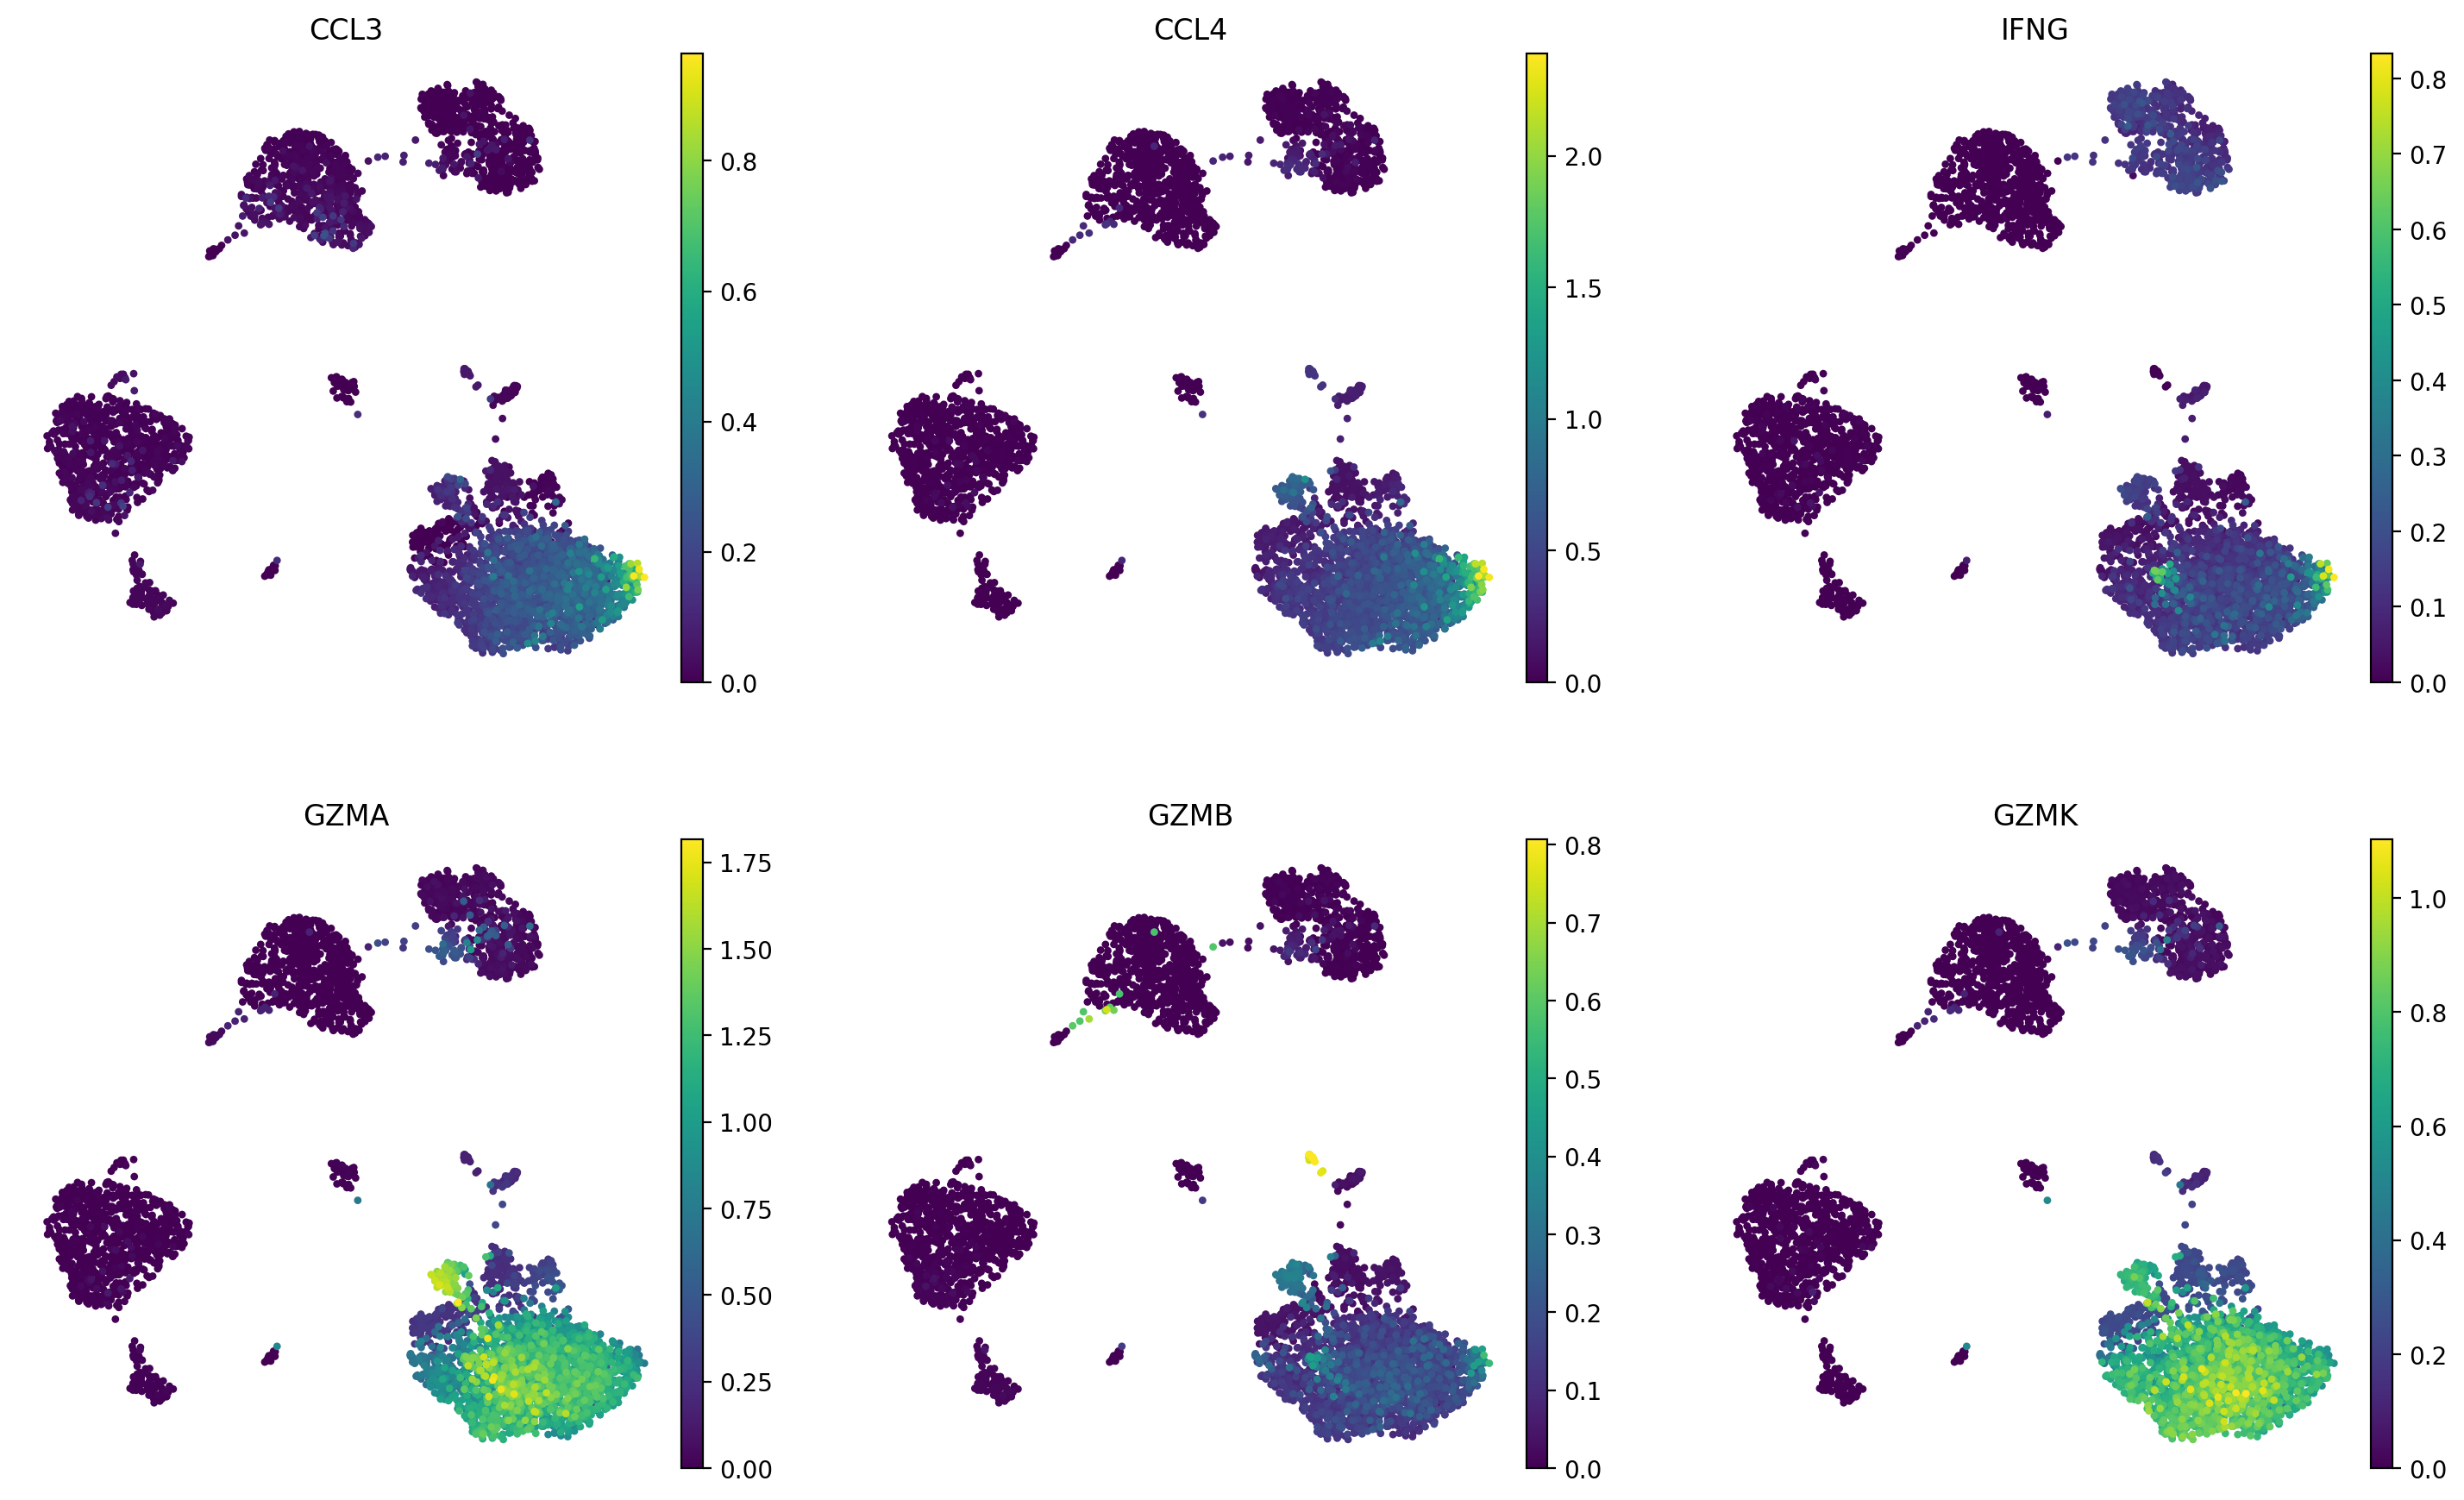

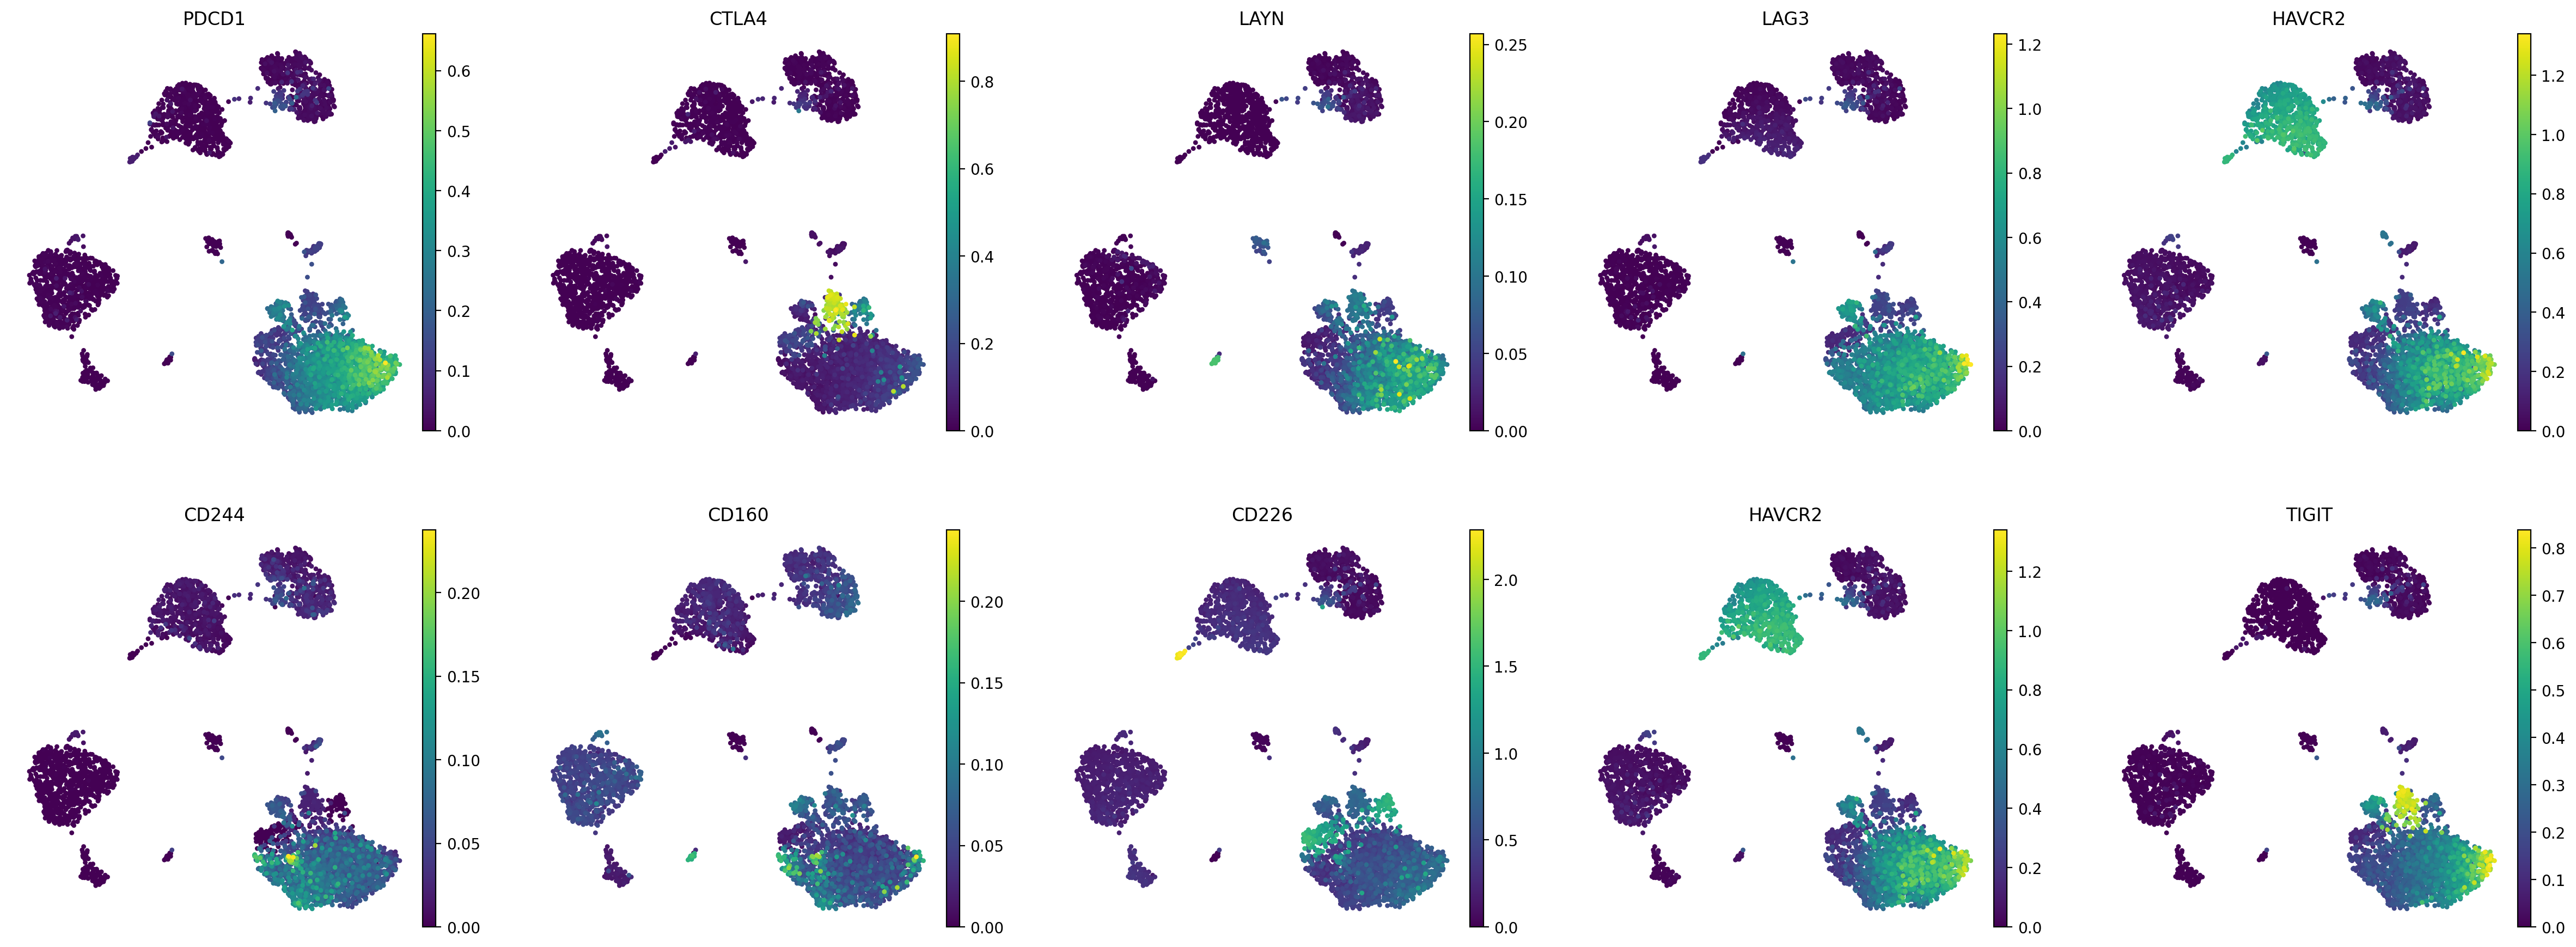

In [6]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 100
sc.pl.umap(adata, color=['CCL3', 'CCL4', 'IFNG', 'GZMA', 'GZMB', 'GZMK'], 
    legend_loc='on data', layer='imputed_count', s=40, frameon=False, ncols=3)


plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 100
exhaustion_markers = ['PDCD1', 'CTLA4', 'LAYN', 'LAG3', 'HAVCR2', 'CD244', 'CD160', 'CD226', 'HAVCR2', 'TIGIT']
sc.pl.umap(adata, color=exhaustion_markers, legend_loc='on data', 
    layer='imputed_count', s=40, frameon=False, ncols=5)

In [7]:
from spaceoracle.gene_factory import GeneFactory

gf = GeneFactory.from_json(
    adata, 
    '/Volumes/SSD/lasso_runs/human_melanoma/run_params.json', 
    override_params={
        'save_dir': '/Volumes/SSD/lasso_runs/human_melanoma'
    }
)

assert len(gf.queue.remaining_genes) == 0

In [8]:
from spaceoracle.beta import Betabase

bdb = Betabase(
    gf.adata, 
    gf.save_dir, 
    subsample=None, 
    float16=True, 
    obs_names=adata.obs_names,
    auto_load=False
)

In [9]:
from spaceoracle.plotting.cartography import xy_from_adata

In [10]:
xy = xy_from_adata(adata)

In [13]:

%%time

interactions = {}

for ct in adata.obs['cell_type'].unique():
    interactions[ct] = bdb.collect_interactions(cell_type=ct, annot='cell_type')

CPU times: user 54min 26s, sys: 13min 59s, total: 1h 8min 25s
Wall time: 43min 36s


In [15]:

# with open('interactions.pkl', 'wb') as f:
#     pickle.dump(interactions, f)

In [180]:
with open('interactions.pkl', 'rb') as f:
    interactions = pickle.load(f)

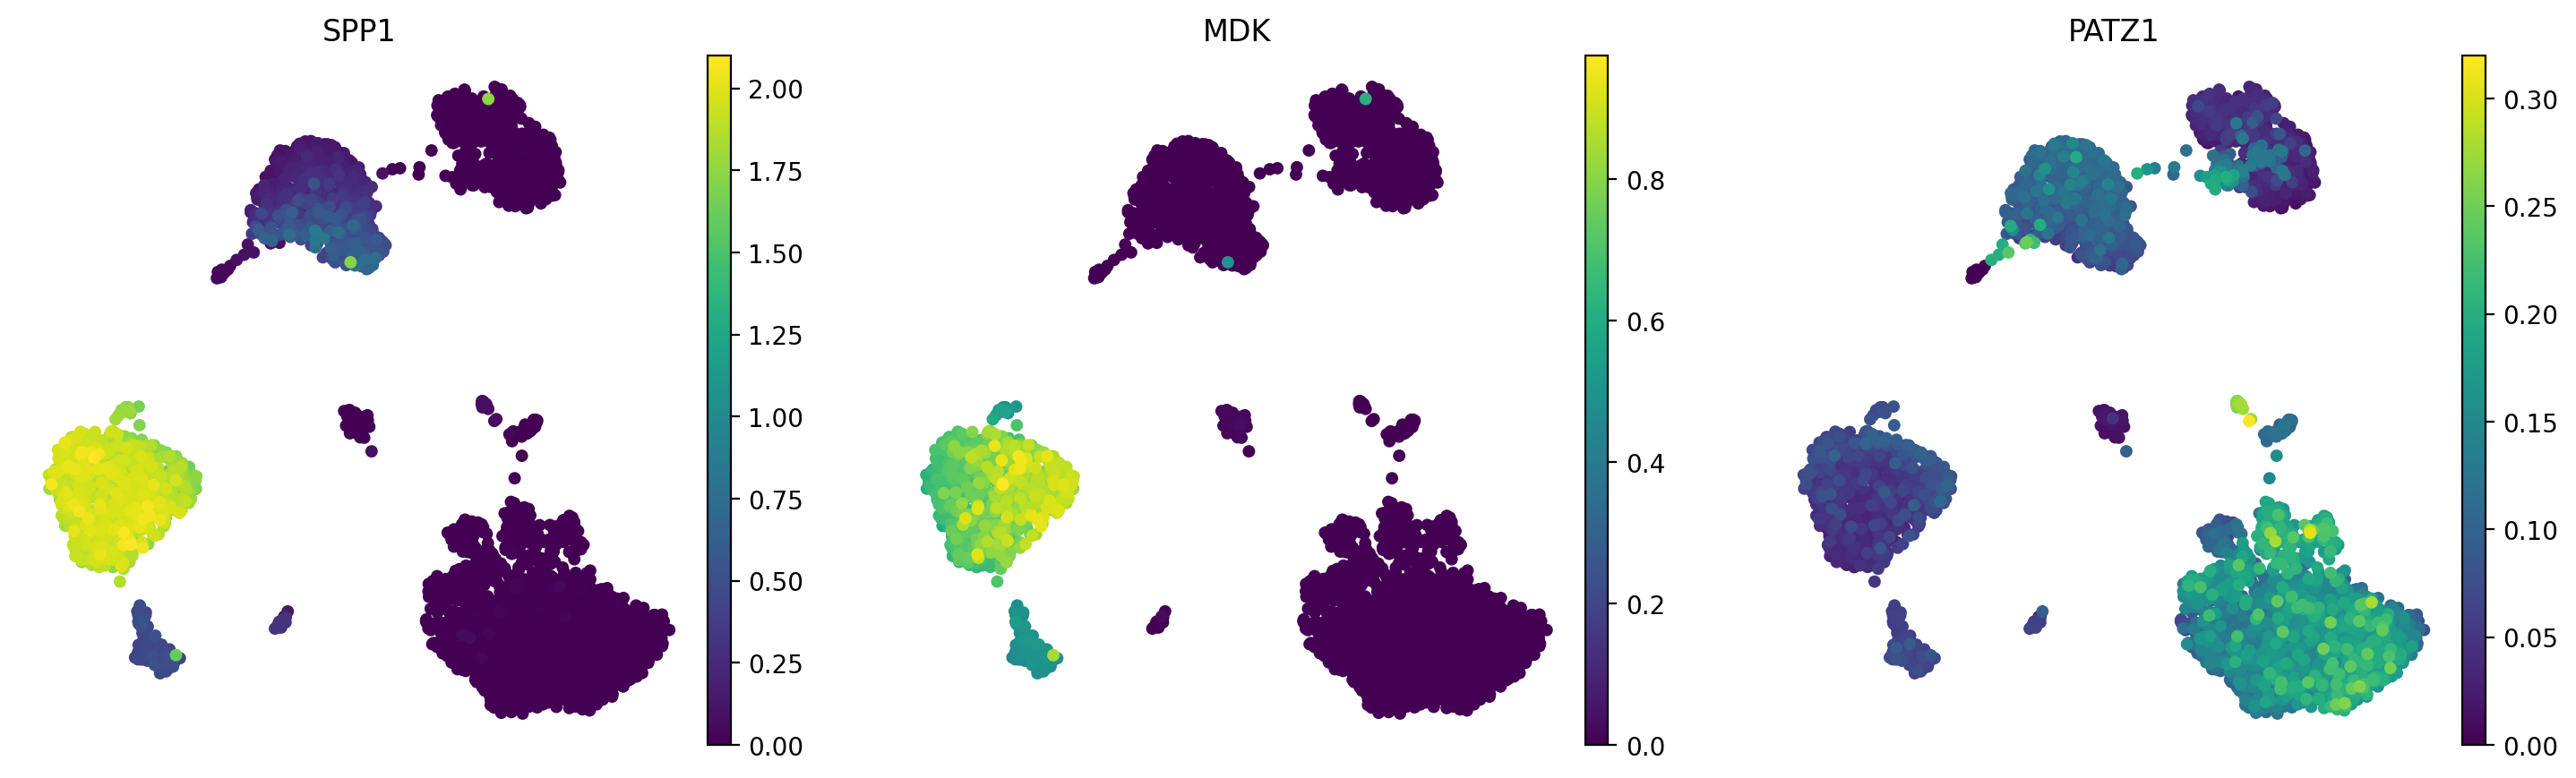

In [225]:

sc.pl.umap(adata, color=['SPP1', 'MDK', 'PATZ1'], s=100, layer='imputed_count', frameon=False)

In [305]:
dfr = interactions['Tumor 1'].query('gene.str.contains("PMEL") and interaction_type=="ligand-receptor"').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)

mean_cd8_expr = adata.to_df(layer='imputed_count')[
    adata.obs.cell_type=='CD8+ T'].mean().to_frame().loc[
        dfr.index.str.replace('beta_', '').str.split('$').str[0].values]

mean_tumor_expr = adata.to_df(layer='imputed_count')[
    adata.obs.cell_type=='Tumor 1'].mean().to_frame().loc[
        dfr.index.str.replace('beta_', '').str.split('$').str[1].values]
    
dfr['mean_cd8_expr'] = mean_cd8_expr.values
dfr['mean_tumor_expr'] = mean_tumor_expr.values
# dfr['weighted_beta'] = dfr['beta'] * dfr['mean_cd8_expr'] * dfr['mean_tumor_expr']
dfr['weighted_beta'] = dfr['beta'] * dfr['mean_cd8_expr']
dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')
top_interactions = dfr[dfr['weighted_beta'] < 0].sort_values(by='weighted_beta', ascending=True).head(15)[::-1]

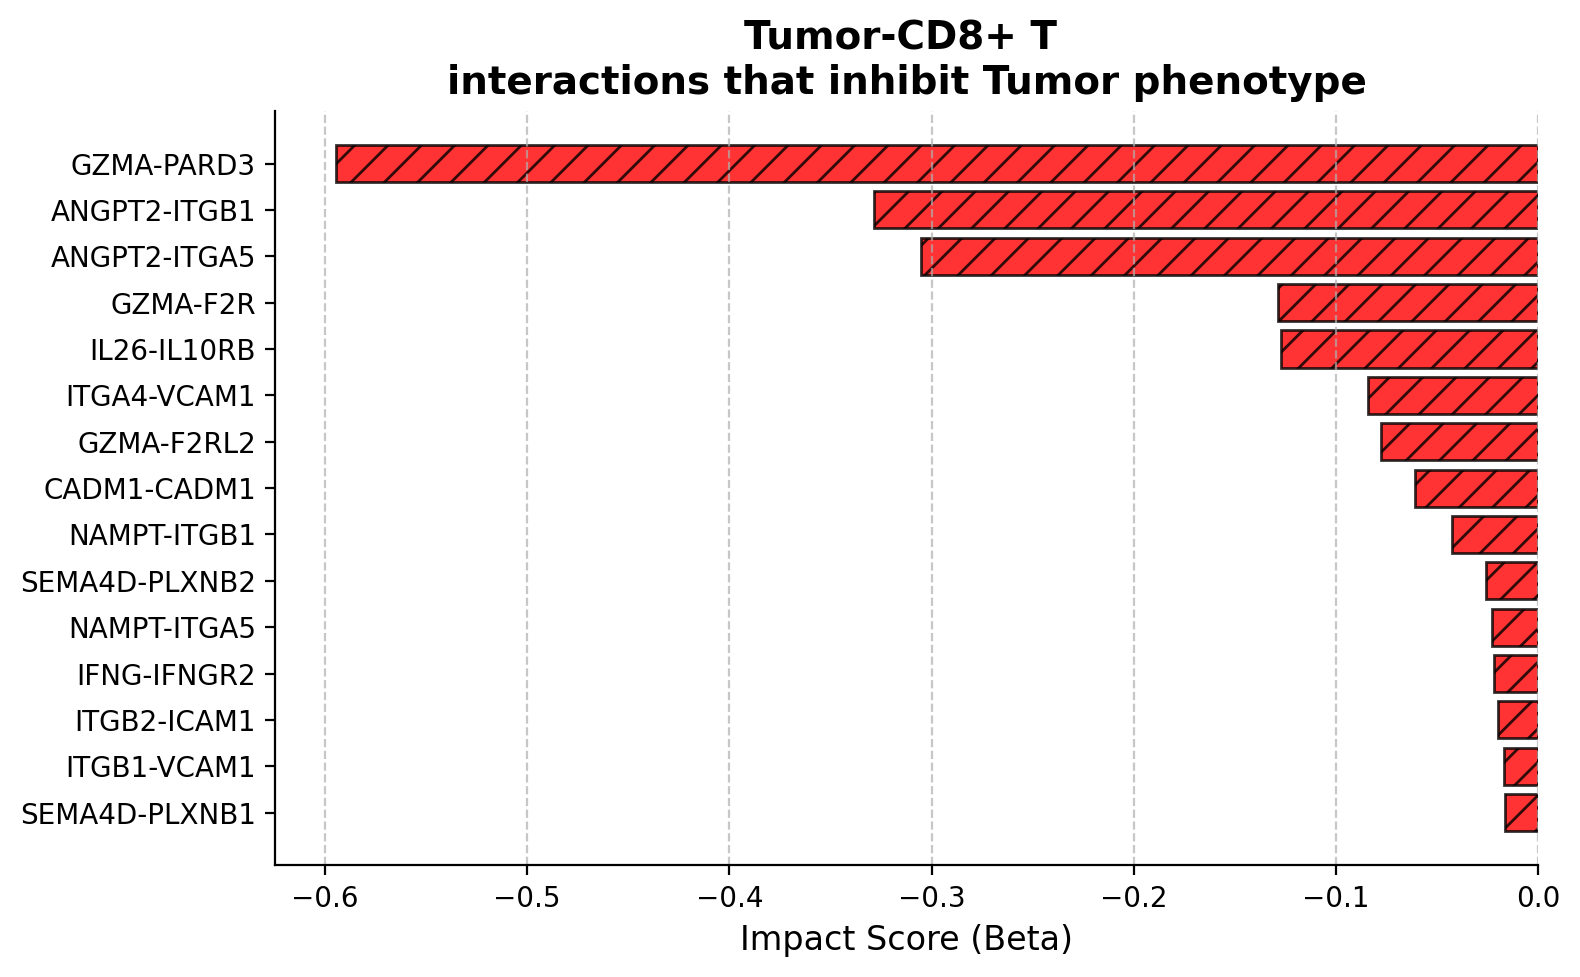

In [306]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
bars = ax.barh(top_interactions.index, top_interactions['weighted_beta'], 
    color='red', edgecolor='black', alpha=0.8, hatch='//')
ylabels = [label.get_text() for label in ax.get_yticklabels()]

ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Tumor-CD8+ T \ninteractions that inhibit Tumor phenotype', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

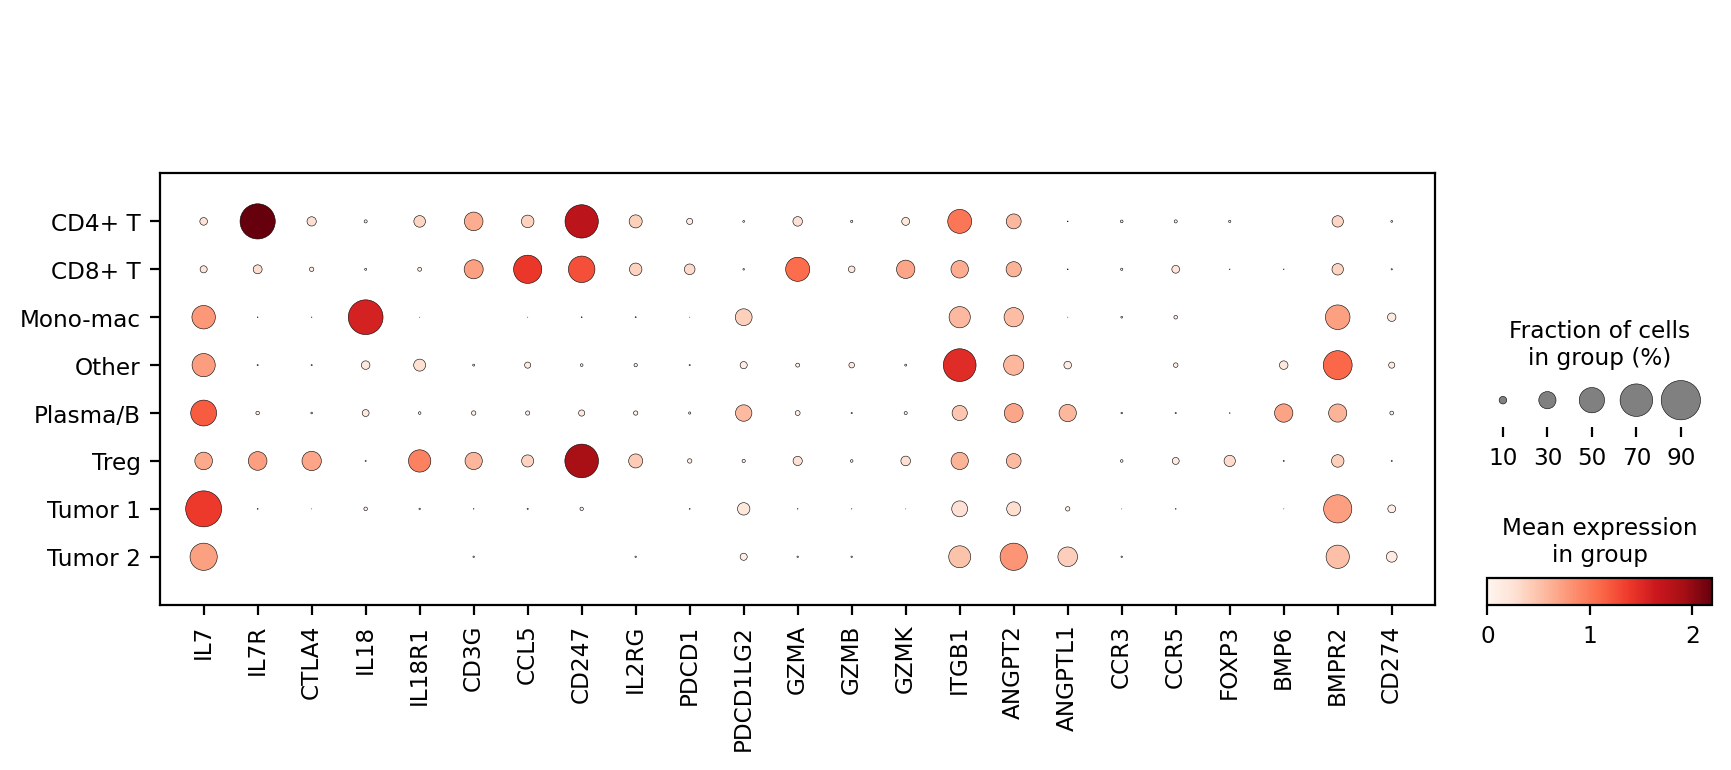

In [307]:
sc.pl.dotplot(adata, groupby='cell_type', 
    var_names=[
        'IL7', 'IL7R', 'CTLA4', 'IL18', 'IL18R1', 
        'CD3G', 'CCL5', 'CD247', 'IL2RG', 'PDCD1', 
        'PDCD1LG2', 'GZMA', 'GZMB', 'GZMK', 'ITGB1', 
        'ANGPT2', 'ANGPTL1', 'CCR3', 'CCR5', 'FOXP3', 
        'BMP6', 'BMPR2', 'CD274'])

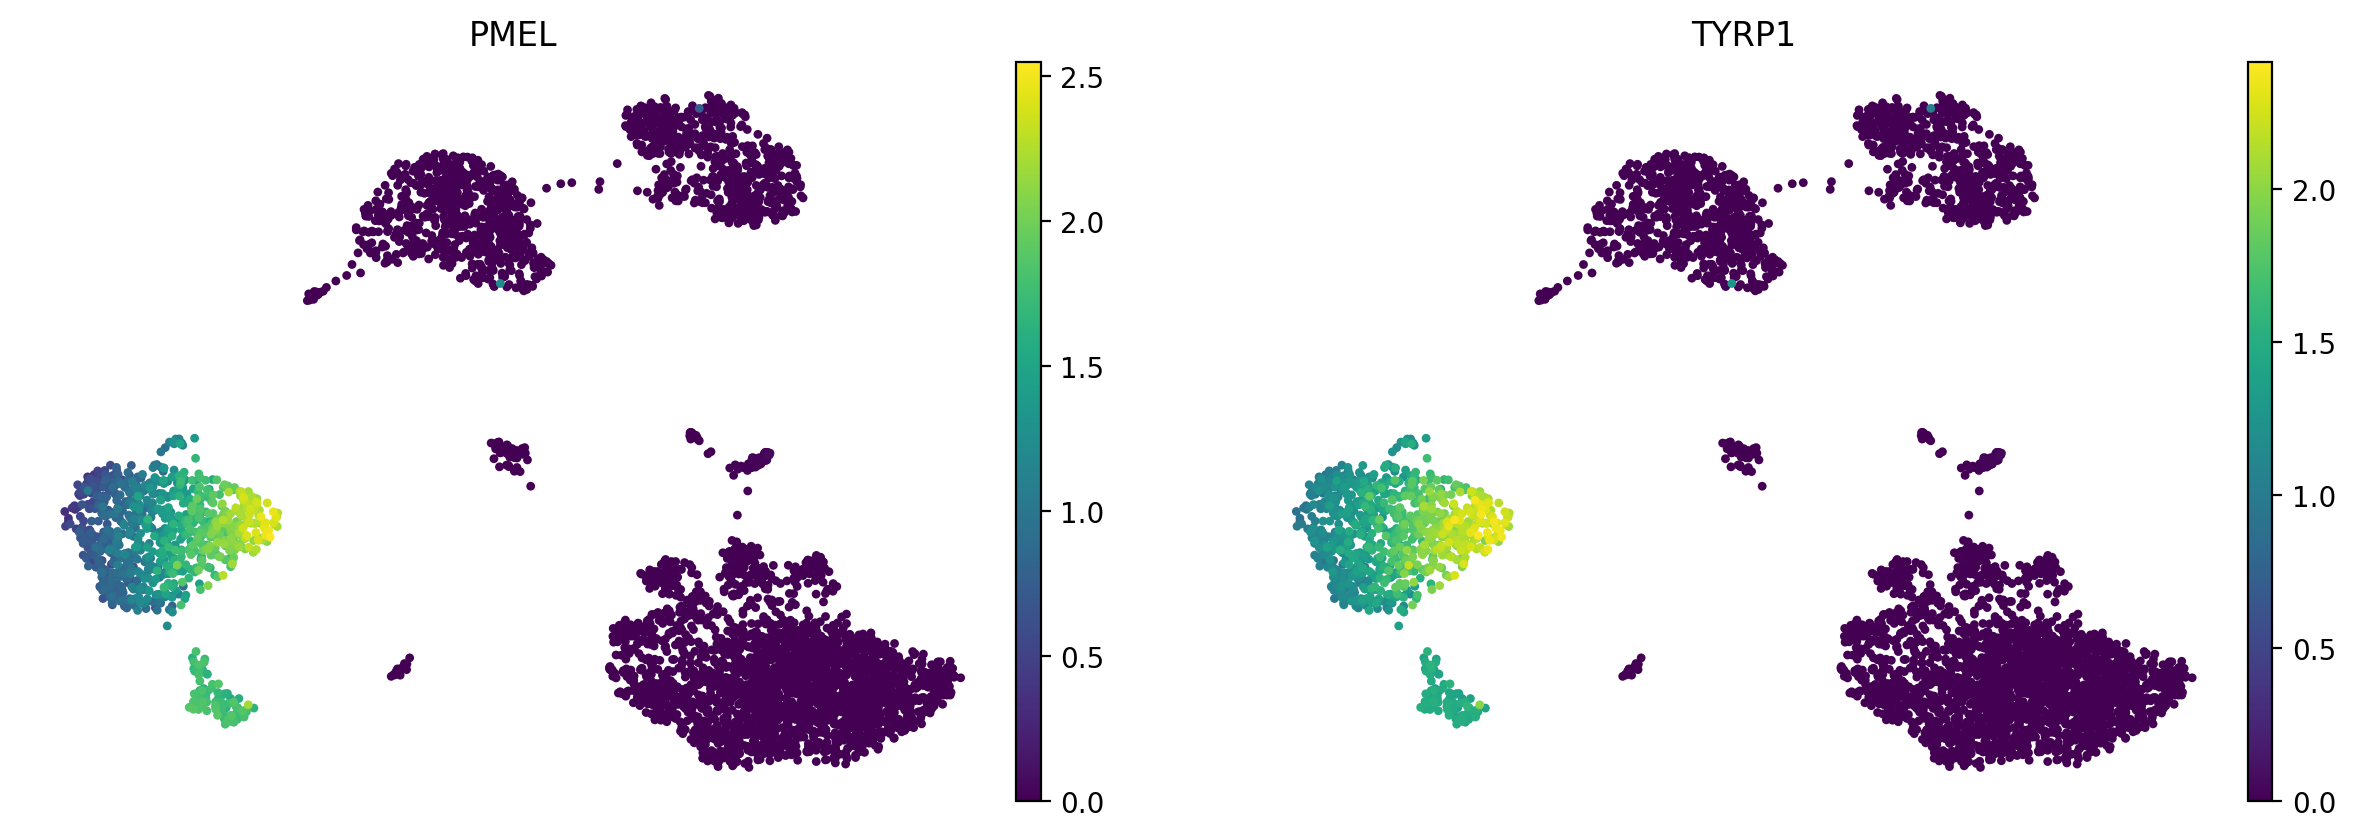

In [49]:
## https://pmc.ncbi.nlm.nih.gov/articles/PMC7851490/
# high activity of these is significantly associated with a poor prognosis
sc.pl.umap(adata, color=['PMEL', 'TYRP1'], 
    legend_loc='on data', layer='imputed_count', s=40, frameon=False)


In [155]:
from spaceoracle.virtual_tissue import VirtualTissue

In [156]:
color_dict = {
    'CD8+ T': '#ce4d3d',
    'Tumor 1': '#58a968', 
    'Mono-mac': '#b05cc6',
    'Plasma/B': '#9ea13d',
    'CD4+ T': '#6e80cc',
    'Treg': '#c1823f',
    'Other': '#cc5692',
    'Tumor 2': '#bf6776'
}

In [157]:
melanoma = VirtualTissue(
    adata = adata,
    annot = 'cell_type',
    # betadatas_path = '/Volumes/SSD/lasso_runs/human_tonsil',
    # ko_path = '/Volumes/SSD/genome_screens/human_melanoma', 
    color_dict=color_dict
)

In [158]:
melanoma.init_cartography(adata)

In [159]:
perturbed_df = pd.read_parquet(f'/Volumes/SSD/genome_screens/melanoma_special/PATZ1_CD8T_KO.parquet')

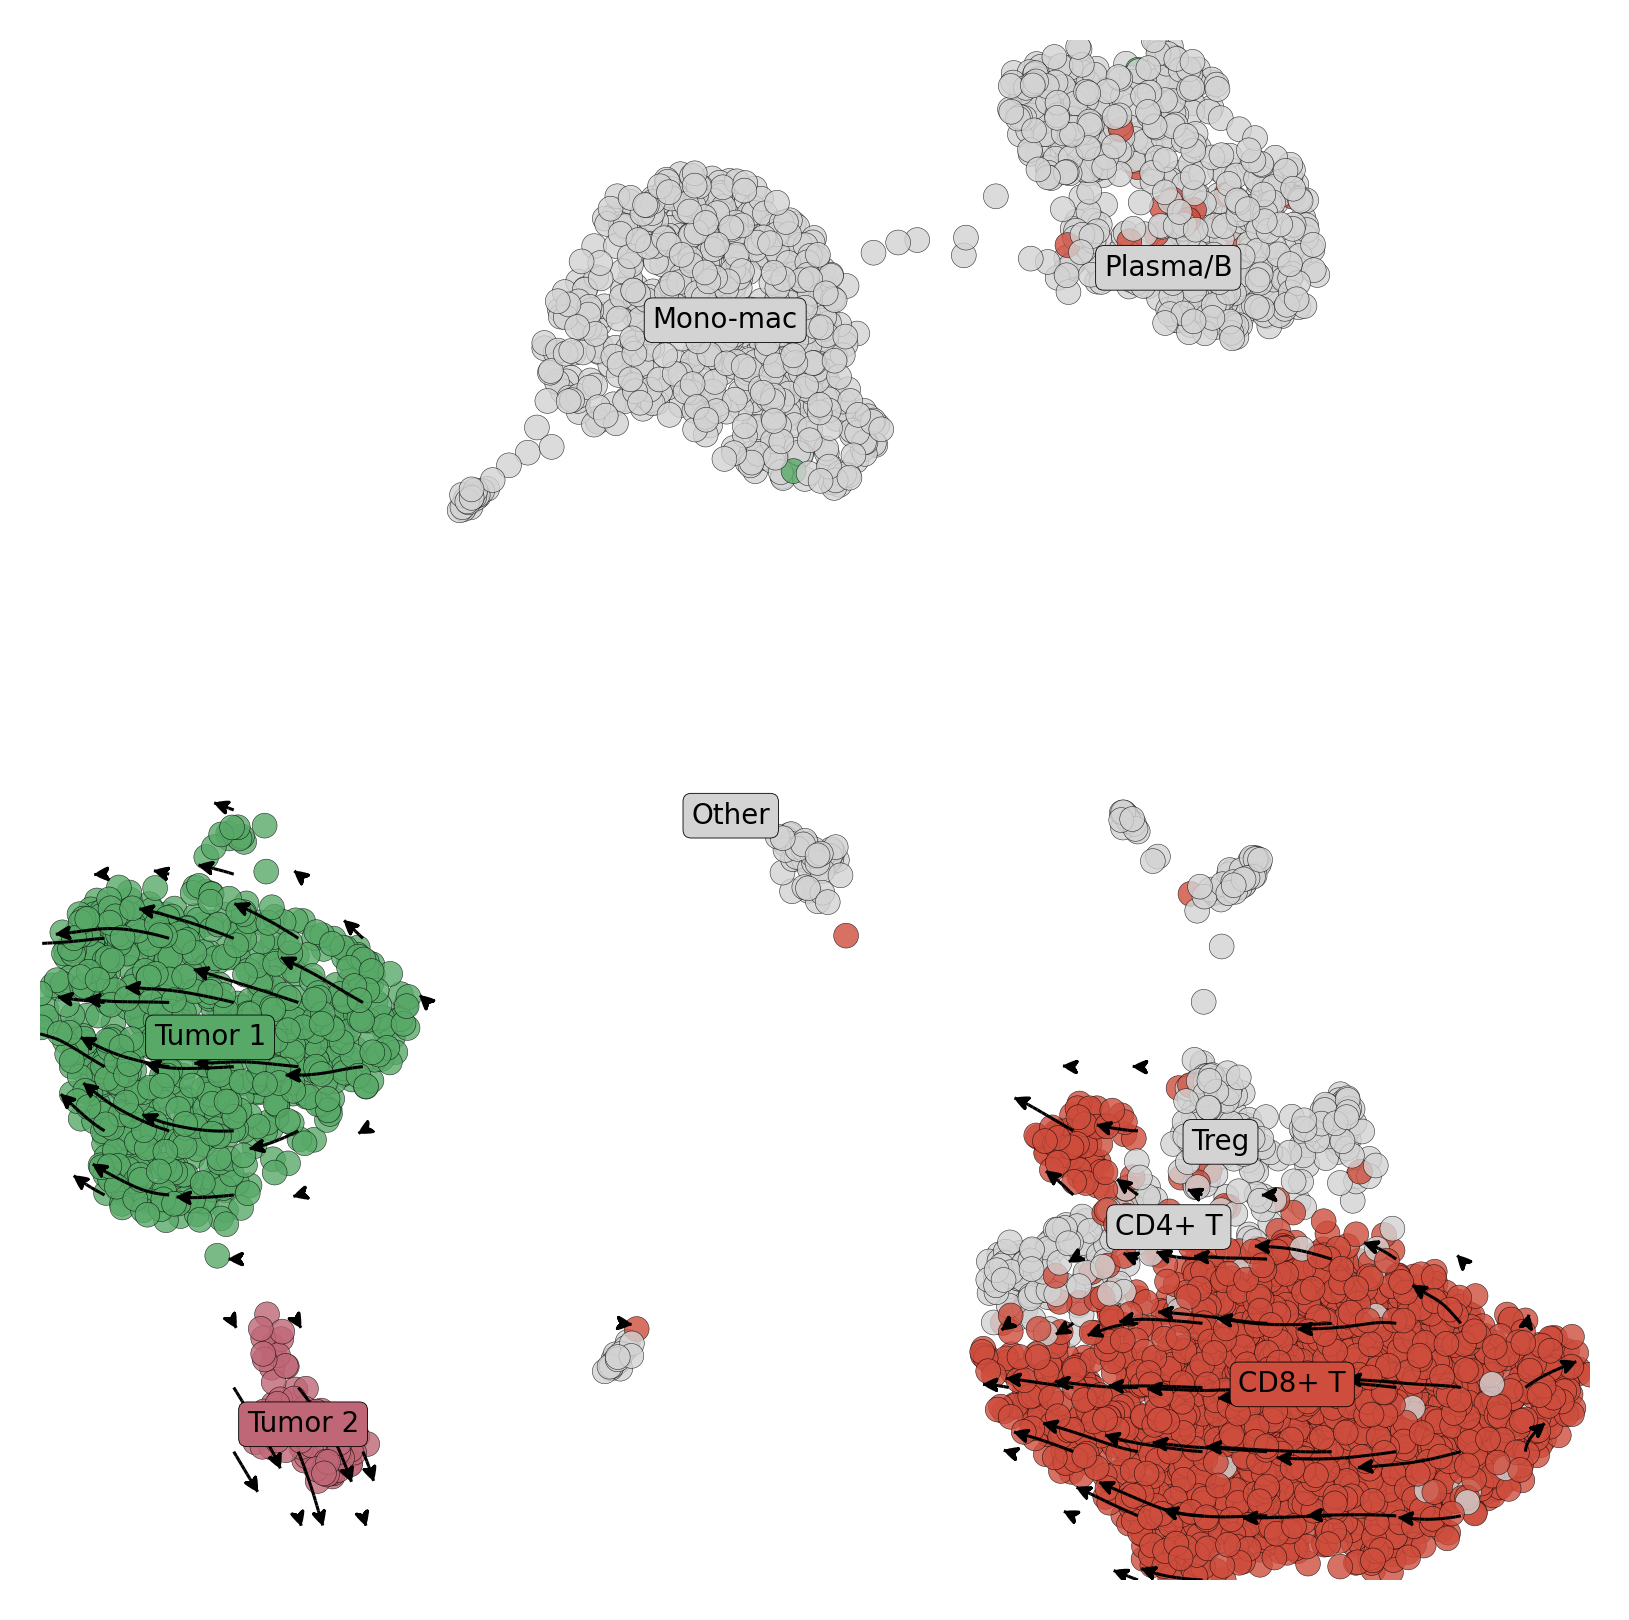

In [315]:
melanoma.plot_arrows(
    perturb_target='', 
    perturbed_df=perturbed_df,
    mode='0',
    hue='cell_type',
    curve=True,
    vector_scale=0.4, 
    grid_scale=2,
    n_neighbors=200,
    scale=3, 
    grains=25,
    figsize=(5, 5),
    dpi=200,
    scatter_size=20,
    legend_fontsize=5,
    limit_clusters=True,
    highlight_clusters=[
        'Tumor 1', 
        'Tumor 2',
        'CD8+ T'
    ]
)

plt.show()

In [325]:
adata.obs.cell_type.value_counts()

cell_type
CD8+ T      2119
Tumor 1      812
Mono-mac     692
Plasma/B     654
CD4+ T       198
Treg         123
Other        119
Tumor 2       87
Name: count, dtype: int64